In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [16]:
!pip3 install catboost

In [17]:
df=pd.read_csv('unusual_drop_preprocess_all_v4.csv')

In [18]:
# Define profitable lending (Profitable = 1, Unprofitable = 0)

df['profitable'] = (df['irr'] > df['treasury']).astype(int)
df['profitable']

0          0
1          0
2          1
3          1
4          0
          ..
1075343    1
1075344    0
1075345    1
1075346    1
1075347    1
Name: profitable, Length: 1075348, dtype: int64

In [19]:
raw_df=pd.read_csv('lending_club_2020_train.csv')

/var/folders/1b/skfph7vx7rvdc6r78s9144580000gn/T/ipykernel_10455/2426208817.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df=pd.read_csv('lending_club_2020_train.csv')


In [20]:
with open('selected_cols_v1.txt', 'r', encoding='utf-8') as f:
    selected_cols_v1 = [line.strip() for line in f if line.strip()]

In [21]:
df_sel = df[selected_cols_v1]
df_sel = pd.concat([df_sel, df['int_rate'], df['treasury'], df['loan_status'], df['funded_amnt'], df['irr'], df['profitable']], axis=1)

In [22]:
with open('categorical_cols_v1.txt', 'r', encoding='utf-8') as f:
    cat_columns_v1 = [line.strip() for line in f if line.strip() != '']

In [23]:
df_cat = df[cat_columns_v1]
df_cat.head()

,addr_state,inq_last_6mths,emp_length,home_ownership,purpose,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_rcnt_il,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,verification_status,grade
0,OK,1,10+ years,MORTGAGE,debt_consolidation,<1yr,unknown,unknown,<1yr,<1yr,<1yr,0,<1yr,Verified,E
1,TX,0,unknown,MORTGAGE,home_improvement,unknown,unknown,unknown,1-2yr,<1yr,unknown,10+,unknown,Not Verified,A
2,FL,0,5 years,MORTGAGE,home_improvement,unknown,unknown,<3yr,2yr+,1-2yr,unknown,6,unknown,Not Verified,B
3,IL,0,10+ years,MORTGAGE,credit_card,3-4yr,4-5yr,unknown,unknown,1-2yr,3-4yr,5,3-4yr,Source Verified,B
4,NC,1,5 years,MORTGAGE,debt_consolidation,unknown,unknown,unknown,1-2yr,1-2yr,unknown,6,unknown,Verified,D


In [24]:
# 범주형 변수들 -> 원핫인코딩
# columns=cat_columns_v1 (리스트 그대로 전달)
df_cat = pd.get_dummies(df_cat, drop_first=True)

# 원본 컬럼 제거: 이미 get_dummies에서 제거되므로, 보통 이 라인은 필요 없음
# 하지만 혹시 모르니 아래처럼, 변수명을 일치시키세요.
df_cat = df_cat.drop(cat_columns_v1, axis=1, errors='ignore')

In [25]:
df_cat.head()

,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,...,mths_since_recent_revol_delinq_<1yr,mths_since_recent_revol_delinq_unknown,verification_status_Source Verified,verification_status_Verified,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
0,False,False,False,False,False,False,False,False,False,False,...,True,False,False,True,False,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,True,False,...,False,True,False,False,True,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,True,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,True,False,True,False,False,True,False,False,False


In [26]:
df_sel = pd.concat([df_sel, df_cat], axis = 1)

In [27]:
# 범주형 변수 남아있는지 체크
obj_cols = df_sel.select_dtypes(include='object').columns
if len(obj_cols) > 0:
    print("아직 문자열 변수 존재:", obj_cols)

In [28]:
# =============================================================
# Two-Stage 모델 + SMOTE + 스케일링 통합 (CatBoost → **LGBM** 버전)
#   1단계 : IRR 회귀(O.O.F) → irr_hat
#   2단계 : irr_hat 포함 + SMOTE + 스케일링 → **LGBM 분류**
# =============================================================
import gc, warnings
import numpy as np, pandas as pd

from sklearn.model_selection import train_test_split, KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier                         # ← LGBM
from xgboost  import XGBRegressor

warnings.filterwarnings("ignore")
SEED = 42

# ------------------------------------------------------------------
# 0) 타깃·제외 컬럼
# ------------------------------------------------------------------
DROP_COLS_STAGE2 = ['irr', 'funded_amnt', 'profitable']
TARGET_REG, TARGET_CLS = 'irr', 'profitable'

# ------------------------------------------------------------------
# 1) 1단계: IRR 회귀 + OOF
# ------------------------------------------------------------------
def clean_feature_names(df):
    df.columns = (
        df.columns.astype(str)
        .str.replace('[', '(', regex=False)
        .str.replace(']', ')', regex=False)
        .str.replace('<', 'lt', regex=False)
        .str.replace('>', 'gt', regex=False)
    )
    return df

X1 = df_sel.drop(columns=[TARGET_REG, TARGET_CLS, 'loan_status', 'funded_amnt'])
X1 = clean_feature_names(X1)
y1 = df_sel[TARGET_REG]

X1_tr, X1_val, y1_tr, y1_val = train_test_split(
    X1, y1, test_size=0.25, stratify=df_sel[TARGET_CLS], random_state=SEED
)

# ---- OOF 예측 ----------------------------------------------------
oof_hat = np.zeros(len(X1))
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

xgb = XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    random_state=SEED,
    n_jobs=-1
)

for tr_idx, val_idx in kf.split(X1):
    xgb.fit(X1.iloc[tr_idx], y1.iloc[tr_idx])
    oof_hat[val_idx] = xgb.predict(X1.iloc[val_idx])

# ---- 전체 train 재학습 → 검증예측 ---------------------------------
xgb_full = XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    random_state=SEED,
    n_jobs=-1
)
xgb_full.fit(X1_tr, y1_tr)
irr_val_hat = xgb_full.predict(X1_val)

# ------------------------------------------------------------------
# 2) 2단계 입력
# ------------------------------------------------------------------
X2_tr = X1_tr.copy(); X2_tr['irr_hat'] = oof_hat[X1_tr.index]
X2_val = X1_val.copy(); X2_val['irr_hat'] = irr_val_hat

y2_tr = df_sel.loc[X2_tr.index, TARGET_CLS]
y2_val = df_sel.loc[X2_val.index, TARGET_CLS]

X2_tr = X2_tr.drop(columns=DROP_COLS_STAGE2, errors='ignore')
X2_val = X2_val.drop(columns=DROP_COLS_STAGE2, errors='ignore')

# ------------------------------------------------------------------
# 3) imblearn 파이프라인 : SMOTE → 전처리 → **LGBM**
# ------------------------------------------------------------------
num_cols = X2_tr.select_dtypes(include=['number']).columns.tolist()
cat_cols = [c for c in X2_tr.columns if c not in num_cols]

preproc = ColumnTransformer([
    ('num', StandardScaler(),                       num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])

pipe = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=SEED)),
    ('prep',  preproc),
    ('clf',   LGBMClassifier(
                  objective       = 'binary',
                  n_estimators    = 500,
                  learning_rate   = 0.05,
                  max_depth       = -1,
                  random_state    = SEED,
                  n_jobs          = -1,
                  subsample       = 0.8,
                  colsample_bytree= 0.8
              ))
])

# ------------------------------------------------------------------
# 4) 학습 & 평가
# ------------------------------------------------------------------
pipe.fit(X2_tr, y2_tr)

prob_val = pipe.predict_proba(X2_val)[:, 1]
pred_val = (prob_val > 0.5).astype(int)

print("\n=== Classification Report ===")
print(classification_report(y2_val, pred_val))
print(f"Validation AUC : {roc_auc_score(y2_val, prob_val):.4f}")

[LightGBM] [Info] Number of positive: 661908, number of negative: 661908
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.321478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9240
[LightGBM] [Info] Number of data points in the train set: 1323816, number of used features: 316
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.57      0.06      0.12     48201
           1       0.83      0.99      0.90    220636

    accuracy                           0.82    268837
   macro avg       0.70      0.53      0.51    268837
weighted avg       0.78      0.82      0.76    268837

Validation AUC : 0.7187


In [32]:
def calc_sharpe_by_thresholds_stat_econ(model, X_val_model, X_val, y_val, irr_col='irr', treasury_col='treasury'):
    # X_val_model: drop_cols가 이미 적용된 DataFrame
    val_pred_prob = model.predict_proba(X_val_model)[:, 1]
    thresholds = np.linspace(0.01, 0.99, 100)
    sharpe_ratios = []

    for t in thresholds:
        val_binary = np.where(val_pred_prob < t, 1, 0)
        val_return = []
        for pred, actual, irr, treasury in zip(val_binary, y_val, X_val[irr_col], X_val[treasury_col]):
            if pred == 0:
                val_return.append(irr)  # 투자
            else:
                val_return.append(treasury)  # 비투자
        val_return = np.array(val_return)
        risk_free = np.array(X_val[treasury_col])
        excess_ret = val_return - risk_free
        if excess_ret.std() > 0:
            sharpe = excess_ret.mean() / excess_ret.std()
        else:
            sharpe = np.nan
        sharpe_ratios.append(sharpe)
    return thresholds, sharpe_ratios, val_pred_prob


최적 threshold  : 0.8415
최대 Sharpe Ratio: 0.1766


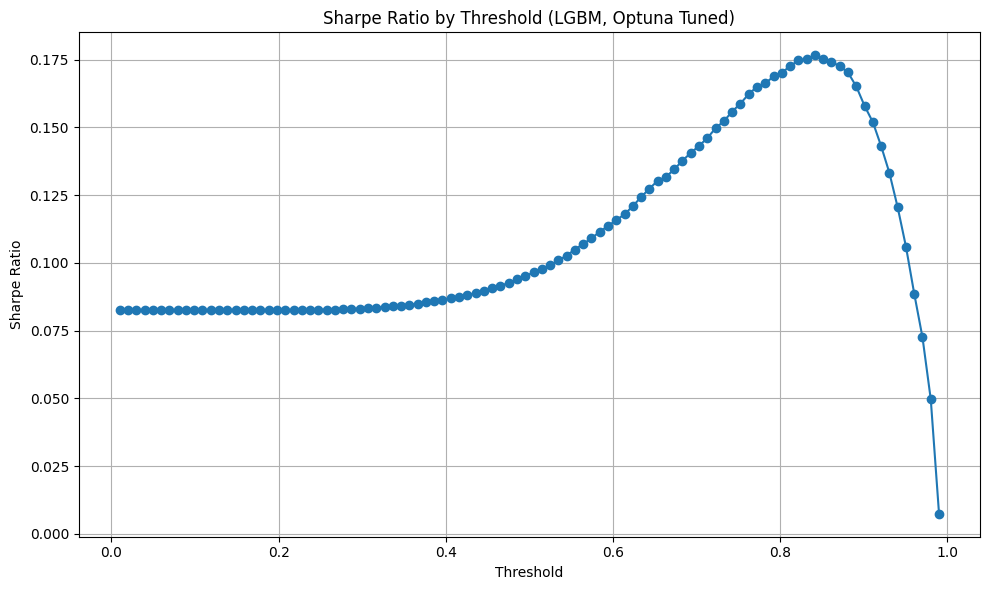

In [ ]:
# ------------------------------------------------------------------
# 0) Sharpe Ratio 계산용 검증 데이터 준비
# ------------------------------------------------------------------
drop_cols = ['treasury', 'funded_amnt', 'irr']  # 필요 시 사용

X_val_eval = X2_val.copy()                      # ← 원본 피처
X_val_eval['irr']      = df_sel.loc[X_val_eval.index, 'irr']
X_val_eval['treasury'] = df_sel.loc[X_val_eval.index, 'treasury']

# ------------------------------------------------------------------
# 1) threshold별 Sharpe Ratio 계산
# ------------------------------------------------------------------
thresholds, sharpe_ratios, val_pred_prob = calc_sharpe_by_thresholds_stat_econ(
    model         = pipe,
    X_val_model   = X2_val,        # ← 앞서 학습 때 썼던 검증 피처
    X_val         = X_val_eval,    # ← IRR·treasury 포함 평가용 테이블
    y_val         = y2_val,
    irr_col       = 'irr',
    treasury_col  = 'treasury'
)

# ------------------------------------------------------------------
# 2) 최적 threshold 및 시각화
# ------------------------------------------------------------------
best_idx = np.nanargmax(sharpe_ratios)
print(f"최적 threshold  : {thresholds[best_idx]:.4f}")
print(f"최대 Sharpe Ratio: {sharpe_ratios[best_idx]:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(thresholds, sharpe_ratios, marker='o')
plt.xlabel("Threshold")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio by Threshold (XGBoost - LGBM)")
plt.grid(True)
plt.tight_layout()
plt.show()